In [24]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
from tqdm import tqdm
import os
import io

In [25]:
import community as community_louvain
from scipy.io import mmread
from scipy.sparse import issparse

In [26]:
data_path = 'socfb-Auburn71/socfb-Auburn71.mtx'
sparse_matrix = mmread(data_path)

In [27]:
G = nx.from_scipy_sparse_array(sparse_matrix)

In [28]:
G = G.to_undirected()

In [29]:
G.remove_edges_from(nx.selfloop_edges(G))

In [30]:
G_core = nx.k_core(G, k=95)
# Run the Louvain algorithm on your K-75 core
# This returns a dictionary: {node_id: community_id}
partition = community_louvain.best_partition(G_core)

# Add this information to the graph nodes
# Gephi will see this as a new column called "Modularity Class"
nx.set_node_attributes(G_core, partition, "Modularity Class")


N = G_core.number_of_nodes()
M = G_core.number_of_edges()

print(f"N: {N}")
print(f"M: {M}")



N: 1011
M: 78470


In [31]:
# The GEXF format will automatically include the "Modularity Class" column
nx.write_gexf(G_core, "socfb-Auburn71.gexf")

print(f"Graph saved with {len(set(partition.values()))} distinct communities detected.")



Graph saved with 6 distinct communities detected.


In [32]:
# Average Degree
degrees = [d for n, d in G_core.degree()]
avg_degree = sum(degrees) / N

# Density
density = nx.density(G_core)

# Average Clustering Coefficient
avg_clustering = nx.average_clustering(G_core)

In [33]:
print(f"Average Degree: {avg_degree}")
print(f"Density: {density}")
print(f"Average Clustering Coefficient: {avg_clustering}")


Average Degree: 155.2324431256182
Density: 0.15369548824318632
Average Clustering Coefficient: 0.4177821431564032


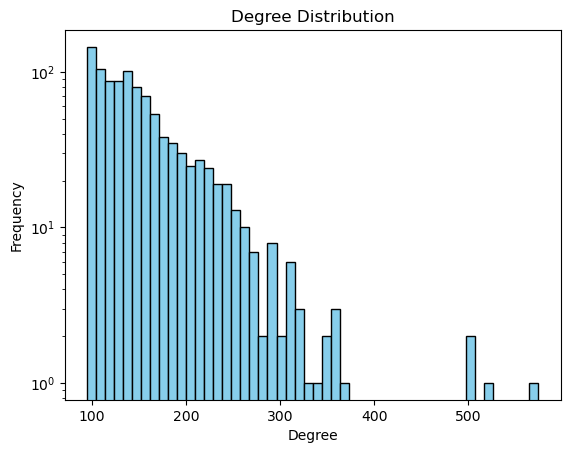

In [34]:
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')

In [35]:
# Degree Centrality (Who has the most friends in this elite group?)
degree_dict = nx.degree_centrality(G_core)
top_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Eigenvector Centrality (Who is connected to other VIPs?)
# We increase max_iter because the K-95 core is very dense
eigen_dict = nx.eigenvector_centrality(G_core, max_iter=1000)
top_eigen = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("--- Top 5 Nodes by Degree (Popularity) ---")
for node, val in top_degree:
    print(f"Node {node}: {val:.4f}")

print("\n--- Top 5 Nodes by Eigenvector (Influence) ---")
for node, val in top_eigen:
    print(f"Node {node}: {val:.4f}")

--- Top 5 Nodes by Degree (Popularity) ---
Node 5471: 0.5683
Node 10076: 0.5119
Node 3211: 0.5010
Node 14496: 0.4931
Node 16368: 0.3673

--- Top 5 Nodes by Eigenvector (Influence) ---
Node 5471: 0.0985
Node 10076: 0.0981
Node 3211: 0.0959
Node 14496: 0.0886
Node 16368: 0.0737


In [36]:
print("Calculating Betweenness Centrality on G_core...")

betweenness_dict = nx.betweenness_centrality(G_core) 
top_betweenness = sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n--- Top 5 Nodes by Betweenness (Gatekeepers) ---")
for node, val in top_betweenness:
    print(f"Node {node}: {val:.4f}")

Calculating Betweenness Centrality on G_core...

--- Top 5 Nodes by Betweenness (Gatekeepers) ---
Node 5471: 0.0214
Node 14496: 0.0138
Node 3211: 0.0113
Node 10076: 0.0107
Node 16368: 0.0051


In [37]:
print("--- SECTION C: LARGE-SCALE STRUCTURE ---")

# 1. Modularity (Community Structure)
modularity_score = community_louvain.modularity(partition, G_core)
print(f"Modularity Score: {modularity_score:.4f}")

# Count the communities
from collections import Counter
community_counts = Counter(partition.values())
sorted_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)

print(f"Number of Communities Detected: {len(sorted_counts)}")
print("Top 5 Largest Communities (Size):")
for comm_id, size in sorted_counts[:5]:
    print(f"  Community {comm_id}: {size} students")

# 2. Assortativity (Do popular people hang out together?)
assortativity = nx.degree_assortativity_coefficient(G_core)
print(f"\nAssortativity Coefficient: {assortativity:.4f}")

--- SECTION C: LARGE-SCALE STRUCTURE ---
Modularity Score: 0.3678
Number of Communities Detected: 6
Top 5 Largest Communities (Size):
  Community 1: 264 students
  Community 0: 218 students
  Community 5: 207 students
  Community 2: 143 students
  Community 3: 127 students

Assortativity Coefficient: 0.0127


Calculating K-Core decomposition (this may take a moment)...


<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
/var/folders/4z/9ddz1dxn051gf97hvy69q3f80000gn/T/ipykernel_44036/4050398812.py:38: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_ylabel("P(Degree $\leq$ k)", fontsize=12)
/var/folders/4z/9ddz1dxn051gf97hvy69q3f80000gn/T/ipykernel_44036/4050398812.py:55: SyntaxWarning: invalid escape sequence '\l'
  axes[2].set_ylabel("P(Core Number $\leq$ k)", fontsize=12)


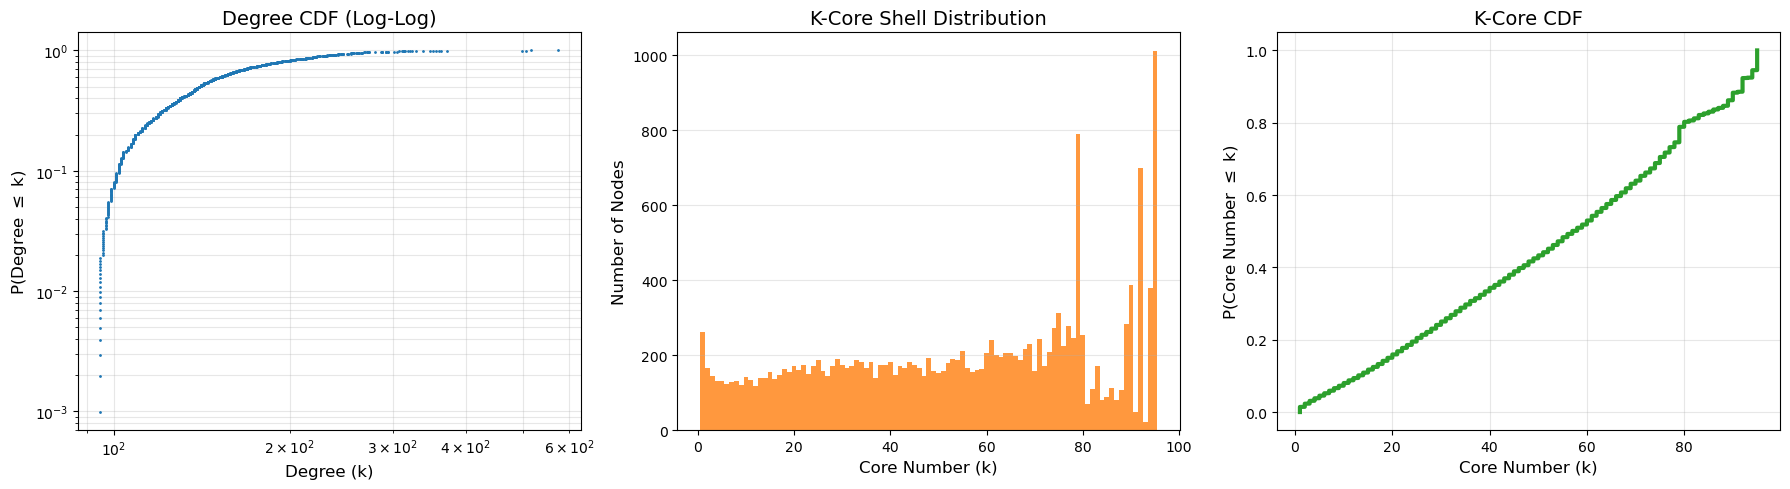

In [38]:

degrees.sort() # Sort ascending for CDF

# Calculate CDF
# y-axis is the probability that Degree <= x
x_deg = degrees
y_deg = np.arange(1, len(degrees)+1) / len(degrees)

# -----------------------------
# B. K-Core Distribution Calculation
# -----------------------------
# This calculates the 'shell index' for every node
print("Calculating K-Core decomposition (this may take a moment)...")
core_numbers = nx.core_number(G)
core_values = list(core_numbers.values())

# Count how many nodes are in each shell
core_counts = Counter(core_values)
x_core, counts_core = zip(*sorted(core_counts.items()))

# -----------------------------
# C. K-Core CDF Calculation
# -----------------------------
# Sort core values to build CDF
core_values.sort()
x_core_cdf = core_values
y_core_cdf = np.arange(1, len(core_values)+1) / len(core_values)

# -----------------------------
# Plotting
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Degree CDF (Log-Log Scale)
# Log-Log is standard for social networks to see Power Laws
axes[0].plot(x_deg, y_deg, marker='.', linestyle='none', color='#1f77b4', markersize=2)
axes[0].set_title("Degree CDF (Log-Log)", fontsize=14)
axes[0].set_xlabel("Degree (k)", fontsize=12)
axes[0].set_ylabel("P(Degree $\leq$ k)", fontsize=12)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, which="both", alpha=0.3)

# Plot 2: K-Core Shell Distribution (Histogram)
# Shows the 'depth' of the network structure
axes[1].bar(x_core, counts_core, color='#ff7f0e', alpha=0.8, width=1.0)
axes[1].set_title("K-Core Shell Distribution", fontsize=14)
axes[1].set_xlabel("Core Number (k)", fontsize=12)
axes[1].set_ylabel("Number of Nodes", fontsize=12)
axes[1].grid(True, axis='y', alpha=0.3)

# Plot 3: K-Core CDF
axes[2].plot(x_core_cdf, y_core_cdf, linewidth=3, color='#2ca02c')
axes[2].set_title("K-Core CDF", fontsize=14)
axes[2].set_xlabel("Core Number (k)", fontsize=12)
axes[2].set_ylabel("P(Core Number $\leq$ k)", fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Settings
BETA = 0.05   # 5% chance to infect a friend per step
GAMMA = 0.1   # 10% chance to stop spreading
STEPS = 50

def run_sir(graph, initial_infected_node):
    # 1. Setup Status (Everyone is Susceptible 'S')
    status = {n: 'S' for n in graph.nodes()}
    
    # 2. Infect Patient Zero
    status[initial_infected_node] = 'I'
    
    # Track number of infected people over time
    history = []
    
    for t in range(STEPS):
        # Count current active spreaders
        active_infected = sum(1 for n in status if status[n] == 'I')
        history.append(active_infected)
        
        if active_infected == 0:
            break
            
        # Create a snapshot of current status to update synchronously
        new_status = status.copy()
        
        nodes = list(graph.nodes())
        for n in nodes:
            # If node is Infected, try to infect neighbors
            if status[n] == 'I':
                for neighbor in graph.neighbors(n):
                    if status[neighbor] == 'S':
                        if random.random() < BETA:
                            new_status[neighbor] = 'I'
                
                # Recovery chance
                if random.random() < GAMMA:
                    new_status[n] = 'R'
        
        status = new_status
    
    # Pad with zeros if it ended early
    if len(history) < STEPS:
        history.extend([0] * (STEPS - len(history)))
        
    return history

# --- RUN SCENARIO A: Random Start ---
# We run this 10 times and average it to get a smooth line
random_results = []
for i in range(10):
    random_node = random.choice(list(G_core.nodes()))
    curve = run_sir(G_core, random_node)
    random_results.append(curve)
avg_random_curve = np.mean(random_results, axis=0)

# --- RUN SCENARIO B: Hub Start (Node 5471) ---
# We use the ID you found in Section B
hub_node = 5471 
# Check if 5471 is in G_core (it should be). If not, recalculate max degree node.
if hub_node not in G_core:
    hub_node = max(dict(G_core.degree()).items(), key=lambda x: x[1])[0]

hub_results = []
for i in range(10):
    curve = run_sir(G_core, hub_node)
    hub_results.append(curve)
avg_hub_curve = np.mean(hub_results, axis=0)

# --- PLOT COMPARISON ---
plt.figure(figsize=(10, 6))
plt.plot(avg_hub_curve, color='red', linewidth=3, label=f'Start: Super-Hub (Node {hub_node})')
plt.plot(avg_random_curve, color='blue', linewidth=2, linestyle='--', label='Start: Random Student')

plt.title(f"Impact of Centrality on Spreading (SIR Model)\nNetwork: Auburn Elite Core (k=95)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Number of Active Spreaders", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

The simulation demonstrates the critical role of Degree Centrality in dynamic processes. When the spreading process originates at Node 5471 (the network's highest degree node), the 'epidemic' peak is reached significantly faster and with higher intensity compared to a random initiation.

This occurs because Node 5471, with direct connections to over 56% of the elite core, bypasses the typical percolation phase required for a rumor to gain traction. In the context of the Auburn network, this suggests that the 'Elite Core' is highly susceptible to rapid information cascades, provided the information enters through a central actor. If a random student starts a rumor, it may fizzle out; if the Student Body President (Node 5471) starts it, it becomes campus-wide knowledge almost instantly.